In [4]:
import os
import zipfile
import kagglehub
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Configurar seeds para reprodutibilidade
tf.random.set_seed(42)
np.random.seed(42)

# Suprimir mensagens de log excessivas do TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


/home/gustavo/notes/artificial-intelligence/AI-Final-Project/.ai-project/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
dataset_path = kagglehub.dataset_download("alxmamaev/flowers-recognition")

print("Caminho do arquivo do dataset:", dataset_path)

# Verificar se o arquivo baixado é um ZIP e extrair
if dataset_path.endswith('.zip'):
    extracted_path = "./dataset"  # Altere este diretório se desejar
    with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print("Dataset extraído para:", extracted_path)
else:
    extracted_path = dataset_path


print("Contents of the extracted dataset folder:")
print(os.listdir(extracted_path))

# List the contents of the 'flower' directory to see the class folders
classes = os.path.join(extracted_path, "flowers")
print("Contents of train directory:")
print(os.listdir(classes))

Caminho do arquivo do dataset: /home/gustavo/.cache/kagglehub/datasets/alxmamaev/flowers-recognition/versions/2
Contents of the extracted dataset folder:
['flowers']
Contents of train directory:
['daisy', 'sunflower', 'tulip', 'dandelion', 'rose']


Using image file: 537207677_f96a0507bb.jpg


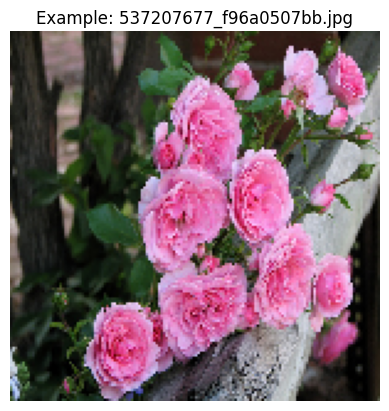

In [6]:
# Construct the path to the 'rose' folder in the training set
rose_folder = os.path.join(extracted_path, "flowers", "rose")
files = os.listdir(rose_folder)

# Check if there are any files and choose the first one as an example
if len(files) > 0:
    chosen_file = files[54] 
    img_path = os.path.join(rose_folder, chosen_file)
    print("Using image file:", chosen_file)
    
    # Load the image with a target size of 150x150 pixels
    img = load_img(img_path, target_size=(150, 150))
    img_array = img_to_array(img)
    
    # Display the image using matplotlib
    plt.imshow(img_array.astype('uint8'))
    plt.title(f"Example: {chosen_file}")
    plt.axis('off')
    plt.show()
else:
    print("No image files found in the 'flowers/rose' folder.")

# Carregar dataset e separar em Treino, Validacao e Teste 

In [7]:
import pathlib
import random

TRAIN_SPLIT_SIZE = 0.7
VALIDATION_SPLIT_SIZE = 0.2

BATCH_SIZE = 16
IMAGE_SIZE = [200, 200]

flowers = daisy_folder = os.path.join(extracted_path, "flowers")

In [8]:
# Function to load and preprocess images
def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG
    image = tf.image.resize(image, IMAGE_SIZE)  # Resize to model input size

    # One-hot encode the label
    label = tf.one_hot(label, 5)  
    return image, label

# Augmentation function
def augment_image(image, label):
    """Applies random augmentation to the image."""
    image = tf.image.random_flip_left_right(image)  
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    # Random zoom (implemented manually)
    scale = random.uniform(0.8, 1.2)  # Random zoom factor
    new_size = [int(200 * scale), int(200 * scale)]
    image = tf.image.resize(image, new_size)
    image = tf.image.resize_with_crop_or_pad(image, 200, 200)  # Crop/Padding back to original size
    
    return image, label

In [9]:
# Define dataset path
dataset_path = pathlib.Path(flowers)

# Get labels from folder names
label_names = sorted(item.name for item in dataset_path.glob('*/') if item.is_dir())
label_to_index = {label: index for index, label in enumerate(label_names)}

# Separate images by class
class_images = {label: [] for label in label_names}

for label in label_names:
    class_folder = dataset_path / label
    image_paths = list(class_folder.glob("*.jpg"))  # Adjust extension if needed
    class_images[label] = [str(path) for path in image_paths]
    random.shuffle(class_images[label])  # Shuffle images within each class

# Splitting each class into train, validation, and test
train_paths, train_labels = [], []
val_paths, val_labels = [], []
test_paths, test_labels = [], []

for label, images in class_images.items():
    total_images = len(images)
    train_size = int(TRAIN_SPLIT_SIZE * total_images)
    val_size = int(VALIDATION_SPLIT_SIZE * total_images)
    test_size = total_images - train_size - val_size  # Remaining for test

    train_paths.extend(images[:train_size])
    train_labels.extend([label_to_index[label]] * train_size)

    val_paths.extend(images[train_size:train_size + val_size])
    val_labels.extend([label_to_index[label]] * val_size)

    test_paths.extend(images[train_size + val_size:])
    test_labels.extend([label_to_index[label]] * test_size)

In [10]:
# Create TensorFlow datasets
original_train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

original_val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

original_test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)) \
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

# Create two augmented versions of the dataset
augmented_dataset_1 = original_train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

train_dataset = original_train_dataset.concatenate(augmented_dataset_1)

augmented_dataset_2 = original_val_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

validation_dataset = original_val_dataset.concatenate(augmented_dataset_2)

augmented_dataset_3 = original_test_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = original_test_dataset.concatenate(augmented_dataset_3)
# Combine original + augmented datasets

# Shuffle, batch, and prefetch
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# validation_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)).map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)).map(load_image).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Print dataset info
print(f"Total Images: {sum(len(v) for v in class_images.values())}")
print(f"Train: {len(train_paths) * 3}, Validation: {len(val_paths) * 3}, Test: {len(test_paths) * 3}")
print(f"Classes: {label_names}")

Total Images: 4317
Train: 9057, Validation: 2580, Test: 1314
Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


# Data Augmentation 

In [11]:
# Create data augmentation pipeline
augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor = (-.25, .3),fill_mode = 'reflect',interpolation = 'bilinear'),
        tf.keras.layers.RandomBrightness(factor = (-.45, .45),value_range = (0.0, 1.0)),
        tf.keras.layers.RandomContrast(factor = (.5)),
    ]
)

# Criando o modelo

In [12]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

# Load VGG-16 model without the top layer (fully connected layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 200, 3))


# Freeze the base model layers (feature extractor)
base_model.trainable = False  

# Build the model
model = Sequential([
    base_model,

    # Additional Conv2D layers for feature learning
    Conv2D(512, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # Flattening the extracted features
    Flatten(),

    # Fully Connected Layers
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),

    # Output layer (5 classes for flower classification)
    Dense(5, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower LR for stability
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 6, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,568,965 (74.65 MB)

 Trainable params: 4,853,253 (18.51 MB)

 Non-trainable params: 14,715,712 (56.14 MB)


# Definição dos Callbacks e Treinamento do Modelo
Nesta célula, definimos os callbacks para melhorar o treinamento:  
- **EarlyStopping:** Para parar o treinamento quando a perda de validação não melhorar e restaurar os melhores pesos.  
- **ReduceLROnPlateau:** Para reduzir a taxa de aprendizado quando a perda de validação parar de melhorar.
Em seguida, treinamos o modelo usando os conjuntos de treinamento e validação.

In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    min_delta=0.001
)

# Define ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=0.00001,
    min_delta=0.001
)

# Train model with callbacks
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr], 
    verbose=1
)


Epoch 1/50
167/378 ━━━━━━━━━━━━━━━━━━━━ 32s 153ms/step - accuracy: 0.5620 - loss: 1.6305

KeyboardInterrupt: 

# Salvando, Carregando e Avaliando o Modelo
 Nesta célula, salvamos o modelo treinado em um arquivo, carregamos esse modelo e o avaliamos no conjunto de teste.

In [ ]:
model.save('flower_trained_model.keras')

In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model('trained_model.keras')

test_loss, test_acc = loaded_model.evaluate(test_dataset)

print(f"\nAcurácia no conjunto de teste: {test_acc:.2%}")

54/55 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2343 - loss: 5.8298

2025-02-26 02:35:32.771296: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[12,512,25,25]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,512,25,25]{3,2,1,0}, f32[512,512,3,3]{3,2,1,0}, f32[512]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-26 02:35:32.771425: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-26 02:35:33.297806: I external/local_xla/xla/service/gp

55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 0.2324 - loss: 5.8589

Acurácia no conjunto de teste: 18.15%


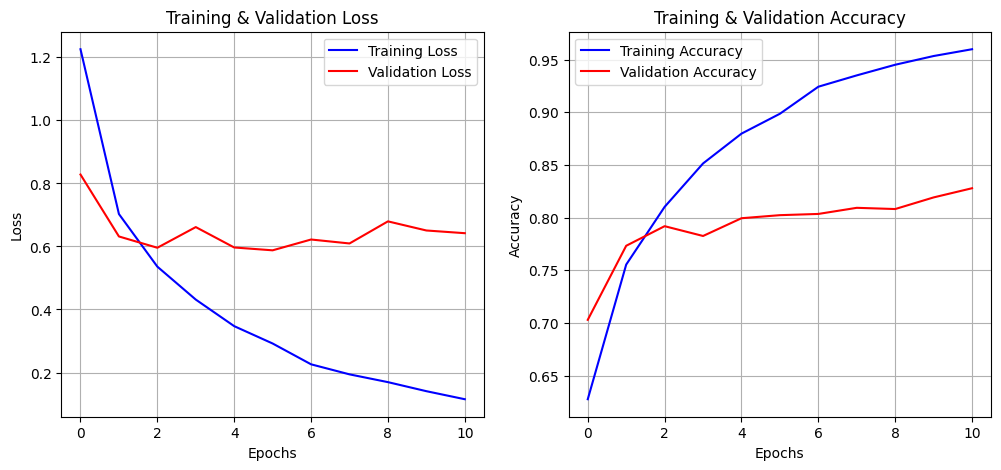

: 

In [ ]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
history_dict = history.history

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss', color='blue')
plt.plot(history_dict['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid(True)

# Show the plots
plt.show()
